Mounted at /content/drive
Resized image saved to: /content/drive/MyDrive/resized.jpg
Seams visualization saved to: /content/drive/MyDrive/seams_visualization.jpg


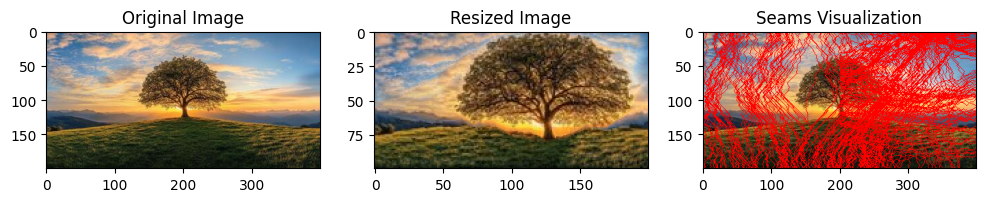

In [4]:
#jana emad-120210006
#razan kenawy-120210059
#nour wassim-120210060
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab import drive

def mount_drive():
    drive.mount('/content/drive', force_remount=True)  # Ensure it's properly mounted
    filepath = "/content/drive/MyDrive/visionproject1.jpg"  # Change to your actual path

    if not os.path.exists(filepath):
        raise FileNotFoundError(f"Error: The file '{filepath}' was not found. Check the path in Google Drive.")

    return filepath

def compute_energy(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).astype(np.float32)
    dx = np.abs(np.gradient(gray, axis=1))  # Approximate ∂I/∂x
    dy = np.abs(np.gradient(gray, axis=0))  # Approximate ∂I/∂y
    return dx + dy

def find_seam(energy):
    h, w = energy.shape
    seam_map = energy.copy()
    backtrack = np.zeros_like(seam_map, dtype=np.int32)

    for i in range(1, h):
        for j in range(w):
            left = seam_map[i - 1, j - 1] if j > 0 else np.inf
            up = seam_map[i - 1, j]
            right = seam_map[i - 1, j + 1] if j < w - 1 else np.inf
            min_energy = min(left, up, right)
            seam_map[i, j] += min_energy
            backtrack[i, j] = np.argmin([left, up, right]) - 1 + j

    seam = []
    j = np.argmin(seam_map[-1])
    for i in range(h - 1, -1, -1):
        seam.append(j)
        j = backtrack[i, j]

    return seam[::-1]

def remove_seam(image, seam):
    h, w, _ = image.shape
    new_image = np.zeros((h, w - 1, 3), dtype=np.uint8)
    for i in range(h):
        new_image[i, :, :] = np.delete(image[i, :, :], seam[i], axis=0)
    return new_image

def visualize_seams(image, vertical_seams, horizontal_seams):
    vis_image = image.copy()

    # Mark vertical seams in red
    for seam in vertical_seams:
        for i in range(len(seam)):
            vis_image[i, seam[i]] = [0, 0, 255]  # Red for vertical seams

    # Rotate image to overlay horizontal seams correctly
    vis_image_rotated = cv2.rotate(vis_image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    for seam in horizontal_seams:
        for i in range(len(seam)):
            vis_image_rotated[i, seam[i]] = [0, 0, 255]  # Green for horizontal seams

    # Rotate back to original orientation
    vis_image = cv2.rotate(vis_image_rotated, cv2.ROTATE_90_CLOCKWISE)

    return vis_image

def seam_carving(image, num_seams):
    seams_removed = []
    for _ in range(num_seams):
        energy = compute_energy(image)
        seam = find_seam(energy)
        seams_removed.append(seam)
        image = remove_seam(image, seam)
    return image, seams_removed

def resize_image(image, new_width, new_height):
    # Reduce width (vertical seams)
    vertical_seams = []
    if new_width < image.shape[1]:
        image, vertical_seams = seam_carving(image, image.shape[1] - new_width)

    # Reduce height (horizontal seams)
    horizontal_seams = []
    if new_height < image.shape[0]:
        image = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)  # Rotate 90° counterclockwise
        image, horizontal_seams = seam_carving(image, image.shape[1] - new_height)
        image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)  # Rotate 90° clockwise to restore

    return image, vertical_seams, horizontal_seams

if __name__ == "__main__":
    filepath = mount_drive()
    img = cv2.imread(filepath)

    if img is None:
        raise ValueError("Error: Unable to read the image. Check the file path and format.")

    new_width = img.shape[1] // 2  # Reduce width by half
    new_height = img.shape[0] // 2  # Reduce height by half
    resized_img, seams_v, seams_h = resize_image(img, new_width, new_height)

    # Create seam visualization
    seam_visualization = visualize_seams(img, seams_v, seams_h)

    output_resized = "/content/drive/MyDrive/resized.jpg"
    output_seams = "/content/drive/MyDrive/seams_visualization.jpg"

    cv2.imwrite(output_resized, resized_img)
    cv2.imwrite(output_seams, seam_visualization)

    print(f"Resized image saved to: {output_resized}")
    print(f"Seams visualization saved to: {output_seams}")

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis("on")

    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB))
    plt.title("Resized Image")
    plt.axis("on")

    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(seam_visualization, cv2.COLOR_BGR2RGB))
    plt.title("Seams Visualization")
    plt.axis("on")

    plt.show()
